# 00__preprocess_counts

in this notebook, i aggregate barcode counts across technical replicates, and merge barcode counts from biological replicates into 1 dataframe. additionally, since hESC reps were sequenced at much higher depth than mESC reps, I downsample the mESC counts in order to accurately compare between the two, and make sure the inequality of sequencing depth isn't biasing anything. finally, i filter barcodes such that they have >= 5 counts in the DNA library, and i filter elements such that every element included has >= 3 barcodes represented at this filter.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions -- move to utils eventually

In [4]:
def import_dna(counts_dir, dna_f):
    dna_dfs = []
    for i in range(len(dna_f)):
        f = dna_f[i]
        cols = ["barcode", "dna_%s" % (i+1)]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t")
        tmp.columns = cols
        dna_dfs.append(tmp)
    if len(dna_dfs) > 1:
        dna = reduce(lambda x, y: pd.merge(x, y, on = "barcode"), dna_dfs)
    else:
        dna = dna_dfs[0]
    return dna

In [5]:
def import_rna(counts_dir, rna_f, dna):
    data = dna.copy()
    data_cols = list(dna.columns)
    for f in rna_f:
        rep = re.findall(r'\d+', f.split("_")[3])[0]
        tmp = pd.read_table("%s/%s" % (counts_dir, f), sep="\t")
        tmp.columns = ["barcode", "rna_%s" % rep]
        data_cols.append("rna_%s" % rep)
        data = data.merge(tmp, on="barcode", how="outer")
    return data, data_cols

## variables

In [6]:
counts_dir = "../../../data/02__mpra/01__counts"

In [7]:
barcode_dna_read_threshold = 5
barcode_rna_read_threshold = 0
n_barcodes_per_elem_threshold = 3

### DNA files

In [8]:
dna_f = ["01__DNA_20180601_BARCODES.txt"]

### RNA files

In [9]:
HUES64_rna_f = ["07__HUES64_rep6_lib1_BARCODES.txt",
                "07__HUES64_rep6_lib2_BARCODES.txt",
                "08__HUES64_rep7_lib1_BARCODES.txt",
                "08__HUES64_rep7_lib2_BARCODES.txt",
                "09__HUES64_rep8_lib1_BARCODES.txt",
                "09__HUES64_rep8_lib2_BARCODES.txt",
                "10__HUES64_rep9_lib1_BARCODES.txt",
                "10__HUES64_rep9_lib2_BARCODES.txt",
                "11__HUES64_rep10_lib1_BARCODES.txt",
                "11__HUES64_rep10_lib2_BARCODES.txt",
                "12__HUES64_rep11_lib1_BARCODES.txt",
                "12__HUES64_rep11_lib2_BARCODES.txt"]
HUES64_out_f = "HUES64__all_counts.txt"

In [10]:
mESC_rna_f = ["15__mESC_rep3_lib1_BARCODES.txt",
              "15__mESC_rep3_lib2_BARCODES.txt"]
mESC_out_f = "mESC__all_counts.txt"

### Index file

In [11]:
index_f = "../../../data/01__design/01__index/TWIST_pool4_v8_final.txt.gz"

## 1. import index

In [12]:
index = pd.read_table(index_f, sep="\t")

In [13]:
index_elem = index[["element", "tile_type"]].drop_duplicates()

## 2. import dna

In [14]:
dna = import_dna(counts_dir, dna_f)
dna.head()

,barcode,dna_1
0,GCGTAATGAAG,0
1,GTTCGACTATG,246
2,TACTAAAGTAC,20
3,ATAACGTGTAA,120
4,TGAGCGGGTTC,1368


## 3. import rna

In [15]:
HUES64_data, HUES64_cols = import_rna(counts_dir, HUES64_rna_f, dna)
HUES64_data.head()

,barcode,dna_1,rna_6_x,rna_6_y,rna_7_x,rna_7_y,rna_8_x,rna_8_y,rna_9_x,rna_9_y,rna_10_x,rna_10_y,rna_11_x,rna_11_y
0,GCGTAATGAAG,0,0,0,0,0,0,0,0,0,0,1,1,0
1,GTTCGACTATG,246,137,2,67,0,0,20,38,8,192,18,337,66
2,TACTAAAGTAC,20,0,0,0,0,0,0,0,12,1,0,0,0
3,ATAACGTGTAA,120,143,0,0,2,1,0,0,13,0,2,8,4
4,TGAGCGGGTTC,1368,36,229,378,160,145,447,270,201,152,294,88,135


In [16]:
mESC_data, mESC_cols = import_rna(counts_dir, mESC_rna_f, dna)
mESC_data.head()

,barcode,dna_1,rna_3_x,rna_3_y
0,GCGTAATGAAG,0,0,0
1,GTTCGACTATG,246,73,12
2,TACTAAAGTAC,20,0,2
3,ATAACGTGTAA,120,0,0
4,TGAGCGGGTTC,1368,248,131


## 4. look at correlation b/w technical replicates

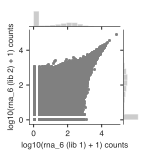

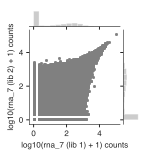

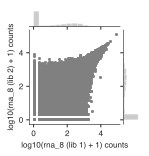

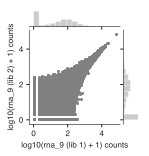

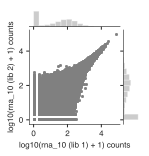

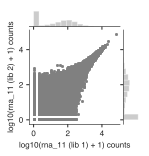

In [17]:
HUES64_reps = ["rna_6", "rna_7", "rna_8", "rna_9", "rna_10", "rna_11"]
for rep in HUES64_reps:
    cols = [x for x in HUES64_data.columns if rep in x]
    sub_df = HUES64_data[cols]
    sub_df[cols] = np.log10(HUES64_data[cols] + 1)
    
    # plot
    g = sns.jointplot(sub_df[cols[0]], sub_df[cols[1]], color="gray", size=2.2,
                      marginal_kws=dict(bins=15),
                      joint_kws=dict(s=5, rasterized=True))
    g.set_axis_labels("log10(%s (lib 1) + 1) counts" % rep, "log10(%s (lib 2) + 1) counts" % rep)
    g.savefig("HUES64_%s_lib_corr_scatter.pdf" % (rep), dpi="figure", bbox_inches="tight")
    plt.show()

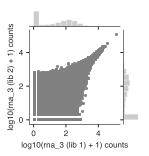

In [18]:
mESC_reps = ["rna_3"]
for rep in mESC_reps:
    cols = [x for x in mESC_data.columns if rep in x]
    sub_df = mESC_data[cols]
    sub_df[cols] = np.log10(mESC_data[cols] + 1)
    
    # plot
    g = sns.jointplot(sub_df[cols[0]], sub_df[cols[1]], color="gray", size=2.2,
                      marginal_kws=dict(bins=15),
                      joint_kws=dict(s=5, rasterized=True))
    g.set_axis_labels("log10(%s (lib 1) + 1) counts" % rep, "log10(%s (lib 2) + 1) counts" % rep)
    g.savefig("mESC_%s_lib_corr_scatter.pdf" % (rep), dpi="figure", bbox_inches="tight")
    plt.show()

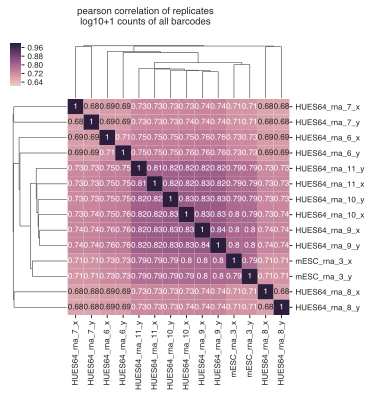

In [19]:
# heatmap incl all libraries
tmp1 = HUES64_data
tmp1_cols = ["barcode", "dna_1"]
tmp1_cols.extend(["HUES64_%s" % x for x in tmp1.columns if "barcode" not in x and "dna" not in x])
tmp1.columns = tmp1_cols

tmp2 = mESC_data
tmp2_cols = ["barcode", "dna_1"]
tmp2_cols.extend(["mESC_%s" % x for x in tmp2.columns if "barcode" not in x and "dna" not in x])
tmp2.columns = tmp2_cols

tmp = tmp1.merge(tmp2, on=["barcode", "dna_1"])
tmp = tmp.set_index("barcode")
tmp.drop("dna_1", axis=1, inplace=True)
tmp_cols = tmp.columns
tmp[tmp_cols] = np.log10(tmp[tmp_cols] + 1)
tmp_corr = tmp.corr(method="pearson")

cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(tmp_corr, figsize=(5, 5), cmap=cmap, annot=True, vmin=0.6)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("pearson correlation of replicates\nlog10+1 counts of all barcodes")
cg.savefig("rep_and_lib_corr_heatmap.pdf", dpi="figure", bbox_inches="tight")

## 5. sum technical replicates

In [20]:
HUES64_data["HUES64_rna_6"] = HUES64_data[["HUES64_rna_6_x", "HUES64_rna_6_y"]].sum(axis=1)
HUES64_data["HUES64_rna_7"] = HUES64_data[["HUES64_rna_7_x", "HUES64_rna_7_y"]].sum(axis=1)
HUES64_data["HUES64_rna_8"] = HUES64_data[["HUES64_rna_8_x", "HUES64_rna_8_y"]].sum(axis=1)
HUES64_data["HUES64_rna_9"] = HUES64_data[["HUES64_rna_9_x", "HUES64_rna_9_y"]].sum(axis=1)
HUES64_data["HUES64_rna_10"] = HUES64_data[["HUES64_rna_10_x", "HUES64_rna_10_y"]].sum(axis=1)
HUES64_data["HUES64_rna_11"] = HUES64_data[["HUES64_rna_11_x", "HUES64_rna_11_y"]].sum(axis=1)
mESC_data["mESC_rna_3"] = mESC_data[["mESC_rna_3_x", "mESC_rna_3_y"]].sum(axis=1)

old_cols = [x for x in HUES64_data.columns if "_x" in x or "_y" in x]
HUES64_data.drop(old_cols, axis=1, inplace=True)
HUES64_cols = HUES64_data.columns

old_cols = [x for x in mESC_data.columns if "_x" in x or "_y" in x]
mESC_data.drop(old_cols, axis=1, inplace=True)
mESC_cols = HUES64_data.columns

HUES64_data.head()

,barcode,dna_1,HUES64_rna_6,HUES64_rna_7,HUES64_rna_8,HUES64_rna_9,HUES64_rna_10,HUES64_rna_11
0,GCGTAATGAAG,0,0,0,0,0,1,1
1,GTTCGACTATG,246,139,67,20,46,210,403
2,TACTAAAGTAC,20,0,0,0,12,1,0
3,ATAACGTGTAA,120,143,2,1,13,2,12
4,TGAGCGGGTTC,1368,265,538,592,471,446,223


sum up technical transfection replicates from a given passage (biological replicates)

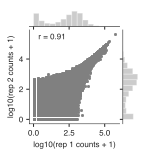

In [21]:
tmp = HUES64_data.copy()
tmp["HUES64_rep_1"] = tmp["HUES64_rna_6"] + tmp["HUES64_rna_7"] + tmp["HUES64_rna_8"]
tmp["HUES64_rep_2"] = tmp["HUES64_rna_9"] + tmp["HUES64_rna_10"] + tmp["HUES64_rna_11"]

tmp[["HUES64_rep_1", "HUES64_rep_2"]] = np.log10(tmp[["HUES64_rep_1", "HUES64_rep_2"]] + 1)
    
# plot
g = sns.jointplot(tmp["HUES64_rep_1"], tmp["HUES64_rep_2"], color="gray", size=2.2, 
                  marginal_kws=dict(bins=15),
                  joint_kws=dict(s=5, rasterized=True))
g.set_axis_labels("log10(rep 1 counts + 1)", "log10(rep 2 counts + 1)")

r, p = spearmanr(tmp["HUES64_rep_1"], tmp["HUES64_rep_2"])
g.ax_joint.annotate( "r = {:.2f}".format(r), ha="left", xy=(0.1, .90), xycoords=g.ax_joint.transAxes, 
                    fontsize=fontsize)
    
g.savefig("HUES64_barcode_counts_scatter.rep1_v_rep2.pdf", dpi="figure", bbox_inches="tight")

In [22]:
tmp = mESC_data.copy()
tmp["mESC_rep_1"] = tmp["mESC_rna_3"]

# # only one rep for now but uncomment when we get new reps
# tmp[["mESC_rep_1", "mESC_rep_2"]] = np.log10(tmp[["mESC_rep_1", "mESC_rep_2"]] + 1)
    
# # plot
# g = sns.jointplot(tmp["mESC_rep_1"], tmp["mESC_rep_2"], color="gray", size=2.2, 
#                   marginal_kws=dict(bins=15),
#                   joint_kws=dict(s=5, rasterized=True))
# g.set_axis_labels("log10(rep 1 counts + 1)", "log10(rep 2 counts + 1)")

# r, p = spearmanr(tmp["mESC_rep_1"], tmp["mESC_rep_2"])
# g.ax_joint.annotate( "r = {:.2f}".format(r), ha="left", xy=(0.1, .90), xycoords=g.ax_joint.transAxes, 
#                     fontsize=fontsize)
    
# g.savefig("mESC_barcode_counts_scatter.rep1_v_rep2.pdf", dpi="figure", bbox_inches="tight")

In [23]:
HUES64_data["rep_1"] = HUES64_data["HUES64_rna_6"] + HUES64_data["HUES64_rna_7"] + HUES64_data["HUES64_rna_8"]
HUES64_data["rep_2"] = HUES64_data["HUES64_rna_9"] + HUES64_data["HUES64_rna_10"] + HUES64_data["HUES64_rna_11"]
HUES64_data = HUES64_data[["barcode", "dna_1", "rep_1", "rep_2"]]
HUES64_cols = list(HUES64_data.columns)
HUES64_data.head()

,barcode,dna_1,rep_1,rep_2
0,GCGTAATGAAG,0,0,2
1,GTTCGACTATG,246,226,659
2,TACTAAAGTAC,20,0,13
3,ATAACGTGTAA,120,146,27
4,TGAGCGGGTTC,1368,1395,1140


In [24]:
mESC_data["rep_1"] = mESC_data["mESC_rna_3"]
mESC_data = mESC_data[["barcode", "dna_1", "rep_1"]]
mESC_cols = list(mESC_data.columns)
mESC_data.head()

,barcode,dna_1,rep_1
0,GCGTAATGAAG,0,0
1,GTTCGACTATG,246,85
2,TACTAAAGTAC,20,2
3,ATAACGTGTAA,120,0
4,TGAGCGGGTTC,1368,379


## 6. downsample HUES64 barcodes

In [25]:
HUES64_data[["rep_1", "rep_2"]].sum()

rep_1    339240801
rep_2    240542933
dtype: int64

In [26]:
mESC_data["rep_1"].sum()

101861249

since HUES64 was sequenced ~3x as deeply, let's downsample these to make it match mESC

In [27]:
# calculate weights per replicate
HUES64_tmp = HUES64_data.copy()
HUES64_tmp["rep_1_p"] = HUES64_tmp["rep_1"]/HUES64_tmp["rep_1"].sum()
HUES64_tmp["rep_2_p"] = HUES64_tmp["rep_2"]/HUES64_tmp["rep_2"].sum()
HUES64_tmp.fillna(0, inplace=True)
HUES64_tmp.head()

,barcode,dna_1,rep_1,rep_2,rep_1_p,rep_2_p
0,GCGTAATGAAG,0,0,2,0.000000e+00,8.314524e-09
1,GTTCGACTATG,246,226,659,6.661935e-07,2.739636e-06
2,TACTAAAGTAC,20,0,13,0.000000e+00,5.404441e-08
3,ATAACGTGTAA,120,146,27,4.303728e-07,1.122461e-07
4,TGAGCGGGTTC,1368,1395,1140,4.112123e-06,4.739279e-06


In [28]:
rep_1_samp_barcs = np.random.choice(list(HUES64_tmp["barcode"]), p=list(HUES64_tmp["rep_1_p"]), size=102000000)
rep_1_samp_barcs[0:5]

array(['GCAACGTATGT', 'CGAAGTTATGG', 'TTCGTTATGAG', 'GGATAGCAGCA',
       'CCTCGAGCTAA'],
      dtype='<U11')

In [29]:
rep_1_samp_barcs_uniq, rep_1_samp_counts = np.unique(rep_1_samp_barcs, return_counts=True)
del rep_1_samp_barcs

In [30]:
rep_1_downsamp = pd.DataFrame({"barcode": rep_1_samp_barcs_uniq, "rep_1": rep_1_samp_counts})
del rep_1_samp_barcs_uniq
del rep_1_samp_counts
rep_1_downsamp.head()

,barcode,rep_1
0,AAAACAAAGTA,2
1,AAAACAAAGTC,2
2,AAAACAAAGTT,10537
3,AAAACAAATGC,118
4,AAAACAAATGG,129


In [31]:
rep_2_samp_barcs = np.random.choice(list(HUES64_tmp["barcode"]), p=list(HUES64_tmp["rep_2_p"]), size=102000000)
rep_2_samp_barcs[0:5]

array(['CCGCTTACTCG', 'TACGTAAGAAT', 'CGGTCAAATAT', 'CCCGTAGATTA',
       'TTAAGTACGCC'],
      dtype='<U11')

In [32]:
rep_2_samp_barcs_uniq, rep_2_samp_counts = np.unique(rep_2_samp_barcs, return_counts=True)
del rep_2_samp_barcs

In [33]:
rep_2_downsamp = pd.DataFrame({"barcode": rep_2_samp_barcs_uniq, "rep_2": rep_2_samp_counts})
del rep_2_samp_barcs_uniq
del rep_2_samp_counts
rep_2_downsamp.head()

,barcode,rep_2
0,AAAACAAAGTA,7
1,AAAACAAAGTC,2
2,AAAACAAAGTT,9654
3,AAAACAAATGC,132
4,AAAACAAATGG,93


In [34]:
HUES64_tmp = HUES64_tmp.merge(rep_1_downsamp, on="barcode", how="left").merge(rep_2_downsamp, on="barcode", how="left")
HUES64_tmp.fillna(0, inplace=True)
HUES64_data = HUES64_tmp[["barcode", "dna_1", "rep_1_y", "rep_2_y"]]
HUES64_data.columns = ["barcode", "dna_1", "rep_1", "rep_2"]
HUES64_data.head()

,barcode,dna_1,rep_1,rep_2
0,GCGTAATGAAG,0,0.0,0.0
1,GTTCGACTATG,246,84.0,280.0
2,TACTAAAGTAC,20,0.0,4.0
3,ATAACGTGTAA,120,48.0,19.0
4,TGAGCGGGTTC,1368,413.0,481.0


## 7. filter barcodes

In [35]:
HUES64_data = HUES64_data.fillna(0)
mESC_data = mESC_data.fillna(0)

In [36]:
HUES64_data_filt = HUES64_data[HUES64_data["dna_1"] >= barcode_dna_read_threshold]
mESC_data_filt = mESC_data[mESC_data["dna_1"] >= barcode_dna_read_threshold]

In [37]:
HUES64_reps = [x for x in HUES64_data_filt.columns if "rep_" in x]
mESC_reps = [x for x in mESC_data_filt.columns if "rep_" in x]

In [38]:
HUES64_data_filt[HUES64_reps] = HUES64_data_filt[HUES64_data_filt > barcode_rna_read_threshold][HUES64_reps]
HUES64_data_filt.head()

,barcode,dna_1,rep_1,rep_2
1,GTTCGACTATG,246,84.0,280.0
2,TACTAAAGTAC,20,NaN,4.0
3,ATAACGTGTAA,120,48.0,19.0
4,TGAGCGGGTTC,1368,413.0,481.0
5,AAACAACGTCC,32,14.0,NaN


In [39]:
mESC_data_filt[mESC_reps] = mESC_data_filt[mESC_data_filt > barcode_rna_read_threshold][mESC_reps]
mESC_data_filt.head()

,barcode,dna_1,rep_1
1,GTTCGACTATG,246,85.0
2,TACTAAAGTAC,20,2.0
3,ATAACGTGTAA,120,NaN
4,TGAGCGGGTTC,1368,379.0
5,AAACAACGTCC,32,2.0


In [40]:
all_names = ["HUES64", "mESC"]

all_dfs = [HUES64_data_filt, mESC_data_filt]

all_cols = [HUES64_cols, mESC_cols]

print("FILTERING RESULTS:")
for n, df, cs in zip(all_names, all_dfs, all_cols):
    index_len = len(index)
        
    dna_barc_len = len(df)
    dna_barc_perc = (float(dna_barc_len)/index_len)*100
    
    print("%s: from %s barcodes to %s at DNA level (%s%%)" % (n, index_len, dna_barc_len, dna_barc_perc))
    
    reps = [x for x in cs if "rep_" in x]
    
    for r in reps:
        rep = r.split("_")[1]
        
        rna_barc_len = sum(~pd.isnull(df[r]))
        rna_barc_perc = (float(rna_barc_len)/index_len)*100
        
        print("\trep %s: %s barcodes at RNA level (%s%%)" % (rep, rna_barc_len, rna_barc_perc))
    print("")

FILTERING RESULTS:
HUES64: from 239653 barcodes to 209258 at DNA level (87.31707927712151%)
	rep 1: 190251 barcodes at RNA level (79.38602896688128%)
	rep 2: 200108 barcodes at RNA level (83.49905905621878%)

mESC: from 239653 barcodes to 209258 at DNA level (87.31707927712151%)
	rep 1: 190183 barcodes at RNA level (79.35765460895546%)



## 8. filter elements

In [41]:
HUES64_data_filt = HUES64_data_filt.merge(index, on="barcode", how="inner")
mESC_data_filt = mESC_data_filt.merge(index, on="barcode", how="inner")

In [42]:
HUES64_barcodes_per_elem = HUES64_data_filt.groupby(["unique_name", "tile_type"])["barcode"].agg("count").reset_index()
HUES64_barcodes_per_elem_neg = HUES64_barcodes_per_elem[HUES64_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]
HUES64_barcodes_per_elem_no_neg = HUES64_barcodes_per_elem[~HUES64_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]

HUES64_barcodes_per_elem_no_neg_filt = HUES64_barcodes_per_elem_no_neg[HUES64_barcodes_per_elem_no_neg["barcode"] >= n_barcodes_per_elem_threshold]
HUES64_total_elems_rep = len(HUES64_barcodes_per_elem_no_neg)
HUES64_total_elems_filt_rep = len(HUES64_barcodes_per_elem_no_neg_filt)

In [43]:
mESC_barcodes_per_elem = mESC_data_filt.groupby(["unique_name", "tile_type"])["barcode"].agg("count").reset_index()
mESC_barcodes_per_elem_neg = mESC_barcodes_per_elem[mESC_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]
mESC_barcodes_per_elem_no_neg = mESC_barcodes_per_elem[~mESC_barcodes_per_elem["tile_type"].isin(["RANDOM", "SCRAMBLED"])]

mESC_barcodes_per_elem_no_neg_filt = mESC_barcodes_per_elem_no_neg[mESC_barcodes_per_elem_no_neg["barcode"] >= n_barcodes_per_elem_threshold]
mESC_total_elems_rep = len(mESC_barcodes_per_elem_no_neg)
mESC_total_elems_filt_rep = len(mESC_barcodes_per_elem_no_neg_filt)

In [44]:
print("ELEMENT FILTERING RESULTS:")
print("HUES64: filtered %s elements to %s represented at >= %s barcodes (%s%%)" % (HUES64_total_elems_rep, HUES64_total_elems_filt_rep,
                                                                                   n_barcodes_per_elem_threshold,
                                                                                   float(HUES64_total_elems_filt_rep)/HUES64_total_elems_rep*100))

ELEMENT FILTERING RESULTS:
HUES64: filtered 13825 elements to 13702 represented at >= 3 barcodes (99.11030741410488%)


In [45]:
print("HUES64: filtered %s elements to %s represented at >= %s barcodes (%s%%)" % (mESC_total_elems_rep, mESC_total_elems_filt_rep,
                                                                                   n_barcodes_per_elem_threshold,
                                                                                   float(mESC_total_elems_filt_rep)/mESC_total_elems_rep*100))

HUES64: filtered 13825 elements to 13702 represented at >= 3 barcodes (99.11030741410488%)


In [46]:
HUES64_good_elems = list(HUES64_barcodes_per_elem_no_neg_filt["unique_name"]) + list(HUES64_barcodes_per_elem_neg["unique_name"])
mESC_good_elems = list(mESC_barcodes_per_elem_no_neg_filt["unique_name"]) + list(mESC_barcodes_per_elem_neg["unique_name"])

In [47]:
HUES64_data_filt = HUES64_data_filt[HUES64_data_filt["unique_name"].isin(HUES64_good_elems)]
mESC_data_filt = mESC_data_filt[mESC_data_filt["unique_name"].isin(mESC_good_elems)]

## 9. heatmap comparing barcode counts [biological replicates only]

In [48]:
HUES64_cols = ["barcode"]
mESC_cols = ["barcode"]

In [49]:
HUES64_cols.extend(["HUES64_%s" % x for x in HUES64_reps])
mESC_cols.extend(["mESC_%s" % x for x in mESC_reps])
HUES64_cols

['barcode', 'HUES64_rep_1', 'HUES64_rep_2']

In [50]:
HUES64_counts = HUES64_data_filt.copy()
mESC_counts = mESC_data_filt.copy()
mESC_counts.head()

,barcode,dna_1,rep_1,element,tile_type,tile_id,name,parse_details,chrom,start,...,tile_start,tile_end,RE_1,RE_2,RE_3,unique_name,snp,dupe_info,oligo,oligo_len
0,GTTCGACTATG,246,85.0,CCCCGGACGGGGATGGTCAGCGGCTGCGGCCGTCTGGCACGCGAAC...,WILDTYPE,10590.1.0.0.9,MOUSE_EVO_TSS__m.2056__tile2,MOUSE_EVO_TSS__m.2056__tile2;WT,chr19,41817819,...,0.0,144.0,0,1,0.0,"MOUSE_EVO_TSS__m.2056__tile2:41817819-41817963,-",none,10590.1.0.0,ACTGGCCGCTTCACTGCCCCGGACGGGGATGGTCAGCGGCTGCGGC...,200
2,ATAACGTGTAA,120,NaN,GGAGGCTGGTGGGGGCCAGATGTGCTAAAGAGATCCAGATGTGAGA...,WILDTYPE_SINGLE_DELETION,5.5.0.76.5,HUMAN_S100A4_PROMOTER,"HUMAN_S100A4_PROMOTER;WT,SINGLEMUT",chr1,153517073,...,456.0,600.0,0,1,0.0,"HUMAN_S100A4_PROMOTER:153518019-153518163,-",none,5.5.0.76,ACTGGCCGCTTCACTGGGAGGCTGGTGGGGGCCAGATGTGCTAAAG...,199
3,TGAGCGGGTTC,1368,379.0,TCTGGGGCGGCATCAGTTTACAAGTTTGTCTTAAGATGCCGTGCGG...,RANDOM,596.3,random_sequence,NaN,NaN,0,...,0.0,0.0,0,1,0.0,random_sequence_596,none,none,ACTGGCCGCTTCACTGTCTGGGGCGGCATCAGTTTACAAGTTTGTC...,200
4,AAACAACGTCC,32,2.0,GGGGCGCGGCGGATTTACGATCCAGTTCACCCCGGCAGGAAACGTT...,WILDTYPE,8091.1.0.0.3,MOUSE_EVO_TSS__m.710__tile2,MOUSE_EVO_TSS__m.710__tile2;WT,chr10,126602330,...,0.0,144.0,0,1,0.0,"MOUSE_EVO_TSS__m.710__tile2:126602330-126602474,+",none,8091.1.0.0,ACTGGCCGCTTCACTGGGGGCGCGGCGGATTTACGATCCAGTTCAC...,200
5,CCTTACGTCAC,1184,400.0,TCCTTTACGTACACCCACGCTTTATAGTTTACAAAGCGATTTCAAC...,FLIPPED_SINGLE_DELETION,2.21.1.72.1,HUMAN_TUG1_PROMOTER,"HUMAN_TUG1_PROMOTER;WT,FLIP,SINGLEMUT",chr22,31363597,...,2280.0,2424.0,0,1,0.0,"HUMAN_TUG1_PROMOTER:31365877-31366021,-",none,"2.21.1.72,2.21.1.73",ACTGGCCGCTTCACTGTCCTTTACGTACACCCACGCTTTATAGTTT...,199


In [51]:
HUES64_counts = HUES64_counts[["barcode", "rep_1", "rep_2"]]
mESC_counts = mESC_counts[["barcode", "rep_1"]]
HUES64_counts.head()

,barcode,rep_1,rep_2
0,GTTCGACTATG,84.0,280.0
2,ATAACGTGTAA,48.0,19.0
3,TGAGCGGGTTC,413.0,481.0
4,AAACAACGTCC,14.0,NaN
5,CCTTACGTCAC,1093.0,615.0


In [52]:
HUES64_counts.columns = HUES64_cols
mESC_counts.columns = mESC_cols
HUES64_cols

['barcode', 'HUES64_rep_1', 'HUES64_rep_2']

In [53]:
all_samples = HUES64_counts.merge(mESC_counts, on="barcode", how="outer")
all_samples.drop("barcode", axis=1, inplace=True)
cols = [x for x in HUES64_cols if x != "barcode"]
all_samples[cols] = np.log10(all_samples[cols]+1)
all_samples_corr = all_samples.corr(method="pearson")

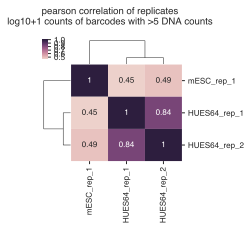

In [54]:
cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(all_samples_corr, figsize=(2.5,2.5), cmap=cmap, annot=True)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("pearson correlation of replicates\nlog10+1 counts of barcodes with >5 DNA counts")
plt.subplots_adjust(top=0.8)
cg.savefig("biological_rep_corr_heatmap_filt.pearson.pdf", dpi="figure", transparent=True, bbox_inches="tight")

In [55]:
all_samples_corr = all_samples.corr(method="spearman")

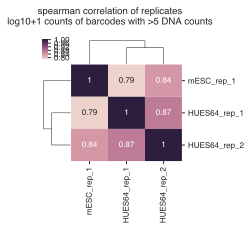

In [56]:
cmap = sns.cubehelix_palette(as_cmap=True)
cg = sns.clustermap(all_samples_corr, figsize=(2.5,2.5), cmap=cmap, annot=True)
_ = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.suptitle("spearman correlation of replicates\nlog10+1 counts of barcodes with >5 DNA counts")
plt.subplots_adjust(top=0.8)
cg.savefig("biological_rep_corr_heatmap_filt.spearman.pdf", dpi="figure", transparent=True, bbox_inches="tight")

## 10. write final files

In [57]:
HUES64_counts = HUES64_data_filt[["barcode", "dna_1", "rep_1", "rep_2"]]
mESC_counts = mESC_data_filt[["barcode", "dna_1", "rep_1"]]

In [58]:
HUES64_counts.to_csv("%s/%s" % (counts_dir, HUES64_out_f), sep="\t", header=True, index=False)

In [59]:
mESC_counts.to_csv("%s/%s" % (counts_dir, mESC_out_f), sep="\t", header=True, index=False)